# The transient universe

Let's go back to our previous example on the astrophysical transient.


8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 12
from scipy import stats
import emcee
import time
import corner
import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot
from scipy.stats import uniform, loguniform

Import transient.npy

In [54]:
data = np.load('/Users/federicoastori/Desktop/ilovegit/WORK_11/transient.npy')



Define the two model functions

In [3]:
def burst_model(b,A,t0,alpha,t): # mylikelihood y=b+A*np.exp(-alpha*(t-t0))
    return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))

def gaussian_model(b,A,t_0,sigma_w,t):
    return (b + A*np.exp(-(t-t_0)**2 / 2*sigma_w**2))
    

Plot the expected posterior pdf

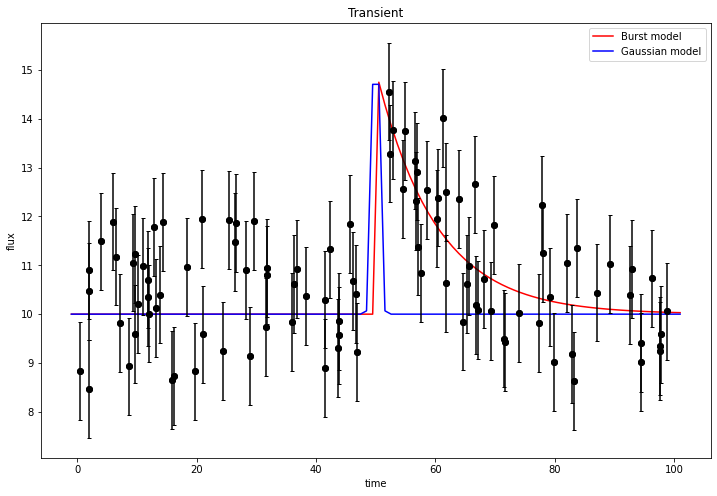

In [20]:
b_par=10
A_par=5
Ag_par=8
t0_par=50
alpha_par=0.1
sigmaW_par=2

xx=np.linspace(-1,101,100)

plt.figure(figsize=(12,8))
plt.plot(xx ,burst_model(b_par,A_par,t0_par,alpha_par,xx), c='red', label=r'Burst model')
plt.plot(xx ,gaussian_model(b_par,Ag_par,t0_par,sigmaW_par,xx), c='blue', label=r'Gaussian model')
plt.scatter(data[:,0],data[:,1], marker='o',color='black')
plt.errorbar(data[:,0],data[:,1],yerr=data[:,2], fmt='o', color='black', capsize=2)
plt.xlabel('time')
plt.ylabel('flux')
plt.title('Transient')
plt.legend(loc=0)

Prior defined with scipy.uniform.ppf, works as well as that I use

In [4]:
'''t0min,t0max = 0,100
Amin,Amax=0,50
bmin,bmax=0,50
alphamin,alphamax=np.exp(-5),np.exp(5)
sigmaWmin,sigmaWmax=np.exp(-2),np.exp(2)

loc=([bmin,Amin,t0min,alphamin,sigmaWmin])
scale=[bmax-bmin,Amax-Amin,t0max-t0min,alphamax-alphamin,sigmaWmax-sigmaWmin]

def LogLikelihood(theta, model=burst_model):
    b,A,t0,alpha = theta
    x, y, sigma_y = data.T
    y_fit = model(b,A,t0,alpha, x)
    return -0.5 * np.sum((y-y_fit)**2 / sigma_y**2 ) 

def ptform(u):
    
    b_prior = uniform.ppf(u[0],loc=loc[0],scale=scale[0])
    A_prior = uniform.ppf(u[1],loc=loc[1],scale=scale[1])
    t_0_prior = uniform.ppf(u[2],loc=loc[2],scale=scale[2])
    alpha = uniform.ppf(u[3],loc=loc[3],scale=scale[3])
    
    x = np.array([b_prior,A_prior,t_0_prior,np.log(alpha)])
    
    return x

########################################################################################################################

def LogLikelihood_gauss(theta_1,model=gaussian_model):
    
    b,A,t_0,sigma_w = theta_1
    
    x,y,sigma_y = data.T
    y_fit = model(b,A,t_0,sigma_w,x)
    return -0.5 * np.sum((y-y_fit)**2 / sigma_y**2 ) 

def ptform_gauss(u):
    
    b_prior = uniform.ppf(u[0],loc=loc[0],scale=scale[0])
    A_prior = uniform.ppf(u[1],loc=loc[1],scale=scale[1])
    t_0_prior = uniform.ppf(u[2],loc=loc[2],scale=scale[2])
    sigma_w = uniform.ppf(u[3],loc=loc[4],scale=scale[4])
    
    x = np.array([b_prior,A_prior,t_0_prior,np.log(sigma_w)]) # translate the points
    
    return x
    
    '''
  



't0min,t0max = 0,100\nAmin,Amax=0,50\nbmin,bmax=0,50\nalphamin,alphamax=np.exp(-5),np.exp(5)\nsigmaWmin,sigmaWmax=np.exp(-2),np.exp(2)\n\nloc=([bmin,Amin,t0min,alphamin,sigmaWmin])\nscale=[bmax-bmin,Amax-Amin,t0max-t0min,alphamax-alphamin,sigmaWmax-sigmaWmin]\n\ndef LogLikelihood(theta, model=burst_model):\n    b,A,t0,alpha = theta\n    x, y, sigma_y = data.T\n    y_fit = model(b,A,t0,alpha, x)\n    return -0.5 * np.sum((y-y_fit)**2 / sigma_y**2 ) \n\ndef ptform(u):\n    \n    b_prior = uniform.ppf(u[0],loc=loc[0],scale=scale[0])\n    A_prior = uniform.ppf(u[1],loc=loc[1],scale=scale[1])\n    t_0_prior = uniform.ppf(u[2],loc=loc[2],scale=scale[2])\n    alpha = uniform.ppf(u[3],loc=loc[3],scale=scale[3])\n    \n    x = np.array([b_prior,A_prior,t_0_prior,np.log(alpha)])\n    \n    return x\n\n########################################################################################################################\n\ndef LogLikelihood_gauss(theta_1,model=gaussian_model):\n    \n    b,A,t_0

By defining the maximum and minimum for the parameters space, and making an affine transform I obtain the hypercube, which define the priors volume for Nested sampling. Basically, these priors are the link between the space where variables lives in a unitary hypercube, and the parameter space of interest. Since the params are independent , I can also use a product of the parmas CDF.

In [5]:
t0min,t0max = 0,100
Amin,Amax=0,50
bmin,bmax=0,50
alphamin,alphamax=np.exp(-5),np.exp(5)
sigmaWmin,sigmaWmax=np.exp(-2),np.exp(2)


def LogLikelihood(theta, model=burst_model):
    b,A,t0,alpha = theta
    x, y, sigma_y = data.T
    y_fit = model(b,A,t0,alpha, x)
    return -0.5 * np.sum((y-y_fit)**2 / sigma_y**2 ) 

def ptform(u):
    
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""
    
    mins = [bmin,Amin,t0min,alphamin]
    maxs = [bmax,Amax,t0max,alphamax]
    
    x = mins + u* maxs-mins
    
    return x

########################################################################################################################

def LogLikelihood_gauss(theta_1,model=gaussian_model):
    
    b,A,t_0,sigma_w = theta_1
    
    x,y,sigma_y = data.T
    y_fit = model(b,A,t_0,sigma_w,x)
    return -0.5 * np.sum((y-y_fit)**2 / sigma_y**2 ) 

def ptform_gauss(u):
    
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""
    
    mins = [bmin,Amin,t0min,sigmaWmin]
    maxs = [bmax,Amax,t0max,sigmaWmax]
    
    
    x = mins + u * maxs-mins
    
    return x
    

Let me call the dynasty nasted sampler

In [6]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(LogLikelihood, ptform, ndim=4, nlive=150) # nlive improve the resolution since the prior volume dosen't change a lot.
sampler.run_nested()
sresults = sampler.results

################################################################

sampler_gauss = dynesty.NestedSampler(LogLikelihood_gauss, ptform_gauss, ndim=4, nlive=150)
sampler_gauss.run_nested()
sresults_gauss = sampler_gauss.results

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
526it [00:00, 442.70it/s, bound: 0 | nc: 27 | ncall: 5276 | eff(%):  9.970 | loglstar:   -inf < -118.090 <    inf | logz: -125.058 +/-  0.202 | dlogz: 34.676 >  0.159]   <ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
588it [00:01, 220.66it/s, bound: 1 | nc: 4 | ncall: 5412 | eff(%): 10.865 | loglstar:   -inf < -99.520 <    inf | logz: -106.564 +/-  0.206 | dlogz: 15.737 >  0.159]  <ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-

1253it [00:13, 16.25it/s, bound: 39 | nc: 200 | ncall: 15191 | eff(%):  8.248 | loglstar:   -inf < -87.090 <    inf | logz: -92.536 +/-  0.180 | dlogz:  3.914 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1255it [00:13, 15.25it/s, bound: 40 | nc: 62 | ncall: 15307 | eff(%):  8.199 | loglstar:   -inf < -87.090 <    inf | logz: -92.535 +/-  0.180 | dlogz:  3.901 >  0.159] <ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1262it [00:13, 21.22it/s, bound: 41 | nc: 6 | ncall: 15463 | eff(%):  8.161 | loglstar:   -inf < -87.090 <    inf | logz: -92.533 +/-  0.180 | dlogz:  3.853 >  0.159] <ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.

1327it [00:17, 18.22it/s, bound: 58 | nc: 309 | ncall: 20305 | eff(%):  6.535 | loglstar:   -inf < -87.090 <    inf | logz: -92.514 +/-  0.180 | dlogz:  4.277 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1329it [00:18, 14.32it/s, bound: 59 | nc: 320 | ncall: 20753 | eff(%):  6.404 | loglstar:   -inf < -87.090 <    inf | logz: -92.514 +/-  0.180 | dlogz:  8.504 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

1360it [00:33,  1.75it/s, bound: 107 | nc: 124 | ncall: 33048 | eff(%):  4.115 | loglstar:   -inf < -87.071 <    inf | logz: -92.508 +/-  0.180 | dlogz: 14.505 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1363it [00:34,  2.70it/s, bound: 109 | nc: 242 | ncall: 33434 | eff(%):  4.077 | loglstar:   -inf < -87.065 <    inf | logz: -92.507 +/-  0.180 | dlogz: 14.485 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1403it [00:47,  2.49it/s, bound: 156 | nc: 983 | ncall: 45574 | eff(%):  3.079 | loglstar:   -inf < -86.897 <    inf | logz: -92.501 +/-  0.180 | dlogz: 27.456 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1407it [00:48,  3.83it/s

1419it [00:53,  2.70it/s, bound: 179 | nc: 532 | ncall: 52039 | eff(%):  2.727 | loglstar:   -inf < -86.812 <    inf | logz: -92.498 +/-  0.180 | dlogz: 27.347 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1420it [00:54,  2.22it/s

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1436it [01:00,  2.32it/s, bound: 209 | nc: 197 | ncall: 59798 | eff(%):  2.401 | loglstar:   -inf < -86.708 <    inf | logz: -92.495 +/-  0.180 | dlogz: 27.232 >  0.159]<ipython-input-3-10dae6e

1461it [01:14,  1.68it/s, bound: 259 | nc: 406 | ncall: 72127 | eff(%):  2.026 | loglstar:   -inf < -86.523 <    inf | logz: -92.491 +/-  0.180 | dlogz: 27.062 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1462it [01:14,  1.82it/s, bound: 260 | nc: 383 | ncall: 72510 | eff(%):  2.016 | loglstar:   -inf < -86.516 <    inf | logz: -92.491 +/-  0.180 | dlogz: 27.055 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1489it [01:27,  2.80it/s, bound: 313 | nc: 1542 | ncall: 85602 | eff(%):  1.739 | loglstar:   -inf < -86.284 <    inf | logz: -92.487 +/-  0.180 | dlogz: 26.871 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1496it [01:32,  1.16it/s, bound: 341 | nc: 2705 | ncall: 92230 | eff(%):  1.622 | loglstar:   -inf < -86.201 <    inf | logz: -92.486 +/-  0.180 | dlogz: 26.823 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1497it [01:33,  1.40it/

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1542it [01:44,  3.36it/s, bound: 386 | nc: 997 | ncall: 104022 | eff(%):  1.482 | loglstar:   -inf < -85.528 <    inf | logz: -92.476 +/-  0.180 | dlogz: 26.508 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1545it [01:44,  4.84it/s, bound: 387 | nc: 7 | ncall: 104206 | eff(%):  1.483 | loglstar:   -inf < -85.500 <    inf | logz: -92.476 +/-  0.180 | dlogz: 26.488 >  0.159]  <ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1547it [01:44,  5.97it/s, bound: 387 | nc: 208 | ncall: 104531 | eff(%):  1.480 | loglstar:   -inf < -85.491 <    inf | lo

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1565it [01:50,  2.35it/s, bound: 411 | nc: 930 | ncall: 110897 | eff(%):  1.411 | loglstar:   -inf < -85.113 <    inf | logz: -92.470 +/-  0.180 | dlogz: 26.349 >  0.159]<ipython-input-3-10dae6

1582it [01:54,  3.07it/s, bound: 434 | nc: 633 | ncall: 117320 | eff(%):  1.348 | loglstar:   -inf < -84.865 <    inf | logz: -92.464 +/-  0.180 | dlogz: 26.231 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1583it [01:54,  3.49it/s, bound: 435 | nc: 232 | ncall: 117552 | eff(%):  1.347 | loglstar:   -inf < -84.851 <    inf | logz: -92.464 +/-  0.180 | dlogz: 26.224 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1622it [02:04,  4.90it/s, bound: 480 | nc: 542 | ncall: 130748 | eff(%):  1.241 | loglstar:   -inf < -84.092 <    inf | logz: -92.446 +/-  0.181 | dlogz: 25.946 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1625it [02:04,  6.08it/s, bound: 481 | nc: 411 | ncall: 131209 | eff(%):  1.238 | loglstar:   -inf < -84.025 <    inf | logz: -92.444 +/-  0.181 | dlogz: 25.925 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1633it [02:09,  1.49it/s, bound: 507 | nc: 1774 | ncall: 137966 | eff(%):  1.184 | loglstar:   -inf < -83.855 <    inf | logz: -92.439 +/-  0.181 | dlogz: 25.866 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1634it [02:10,  1.79it/s, bound: 508 | nc: 423 | ncall: 138389 | eff(%):  1.181 | loglstar:   -inf < -83.839 <    inf | logz: -92.438 +/-  0.181 | dlogz: 25.859 >  0.159] <ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alph

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

1660it [02:22,  1.15it/s, bound: 586 | nc: 1900 | ncall: 157898 | eff(%):  1.051 | loglstar:   -inf < -83.362 <    inf | logz: -92.417 +/-  0.182 | dlogz: 25.666 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1661it [02:23,  1.30it

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

1684it [02:40,  1.40it/s, bound: 700 | nc: 1356 | ncall: 185656 | eff(%):  0.907 | loglstar:   -inf < -82.901 <    inf | logz: -92.391 +/-  0.184 | dlogz: 25.480 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1686it [02:41,  2.07it/s, bound: 701 | nc: 333 | ncall: 186177 | eff(%):  0.906 | loglstar:   -inf < -82.872 <    inf | logz: -92.388 +/-  0.184 | dlogz: 25.465 >  0.159] <ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1699it [02:46,  1.84it/s, bound: 726 | nc: 1320 | ncall: 192838 | eff(%):  0.881 | loglstar:   -inf < -82.661 <    inf | logz: -92.372 +/-  0.185 | dlogz: 25.362 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1733it [03:10,  3.20it/s, bound: 867 | nc: 584 | ncall: 226853 | eff(%):  0.764 | loglstar:   -inf < -81.884 <    inf | logz: -92.314 +/-  0.189 | dlogz: 25.079 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1741it [03:20,  1.23s/it, bound: 926 | nc: 4917 | ncall: 240862 | eff(%):  0.723 | loglstar:   -inf < -81.717 <    inf | logz: -92.295 +/-  0.190 | dlogz: 25.007 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1768it [04:16,  1.88s/it, bound: 1283 | nc: 2247 | ncall: 324193 | eff(%):  0.545 | loglstar:   -inf < -81.302 <    inf | logz: -92.226 +/-  0.195 | dlogz: 30.963 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10da

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1790it [05:45,  4.18s/it, bound: 1868 | nc: 18830 | ncall: 457825 | eff(%):  0.391 | loglstar:   -inf < -80.898 <    inf | logz: -92.152 +/-  0.201 | dlogz: 30.743 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10d

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1794it [05:49,  1.86s/it, bound: 1897 | nc: 724 | ncall: 464688 | eff(%):  0.386 | loglstar:   -inf < -80.778 <    inf | logz: -92.137 +/-  0.202 | dlogz: 30.702 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1795it [05:55,  2.83s/it, bound: 1928 | nc: 7109 | ncall: 471797 | eff(%):  0.380 | loglstar:   -inf < -80.740 <    inf | logz: -92.133 +/-  0.202 | dlogz: 30.692 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10da

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

1807it [06:37,  6.62s/it, bound: 2170 | nc: 27173 | ncall: 527286 | eff(%):  0.343 | loglstar:   -inf < -80.371 <    inf | logz: -92.079 +/-  0.206 | dlogz: 30.559 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10d

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

1815it [08:04, 10.03s/it, bound: 2668 | nc: 10312 | ncall: 640640 | eff(%):  0.283 | loglstar:   -inf < -80.231 <    inf | logz: -92.039 +/-  0.208 | dlogz: 30.466 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10d

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overfl

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overfl

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1825it [09:34,  7.87s/it, bound: 3068 | nc: 1006 | ncall: 731370 | eff(%):  0.250 | loglstar:   -inf < -80.172 <    inf | logz: -91.989 +/-  0.212 | dlogz: 30.349 >  0.159] <ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10d

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1828it [10:03,  9.04s/it, bound: 3193 | nc: 5664 | ncall: 759703 | eff(%):  0.241 | loglstar:   -inf < -80.078 <    inf | logz: -91.974 +/-  0.213 | dlogz: 30.314 >  0.159] <ipython-input-3-10d

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1830it [10:11,  6.47s/it, bound: 3223 | nc: 5567 | ncall: 766785 | eff(%):  0.239 | loglstar:   -inf < -80.035 <    inf | logz: -91.963 +/-  0.213 | dlogz: 30.290 >  0.159]<ipython-input-3-10da

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1832it [10:17,  4.80s/it, bound: 3254 | nc: 4143 | ncall: 774007 | eff(%):  0.237 | loglstar:   -inf < -79.978 <    inf | logz: -91.953 +/-  0.214 | dlogz: 30.267 >  0.159]<ipython-input-3-10da

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overfl

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1837it [10:30,  2.63s/it, bound: 3312 | nc: 1178 | ncall: 787734 | eff(%):  0.233 | loglstar:   -inf < -79.917 <    inf | logz: -91.925 +/-  0.216 | dlogz: 30.206 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
1838it [10:30,  1.97s/it, bound: 3314 | nc: 454 | ncall: 788188 | eff(%):  0.233 | loglstar:   -inf < -79.905 <    inf | logz: -91.920 +/-  0.216 | dlogz: 30.

<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow en

1879it [10:42,  3.31it/s, bound: 3361 | nc: 887 | ncall: 801244 | eff(%):  0.235 | loglstar:   -inf < -78.440 <    inf | logz: -91.575 +/-  0.236 | dlogz: 29.583 >  0.159]<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in exp
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae6e0b96b>:2: RuntimeWarning: overflow encountered in multiply
  return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))
<ipython-input-3-10dae

For the below cells I plot twice both for gaussian and burst model. In this way I can compare the algorithm and in particular derive the evidence.

A powerfull summary of the sampler is visualize below. We can see the relationship between the prior volume (lnX) and:

    - the iteration = how quikly/slowly our samples are compressing the prior volume
    - the likelihood = how smoothly we sample towards the MLE (overcome the likelihood surface)
    - the importance weight = where the bulk of the posterior pdf is located
    - the evidence = where their contributs comes from and the related error

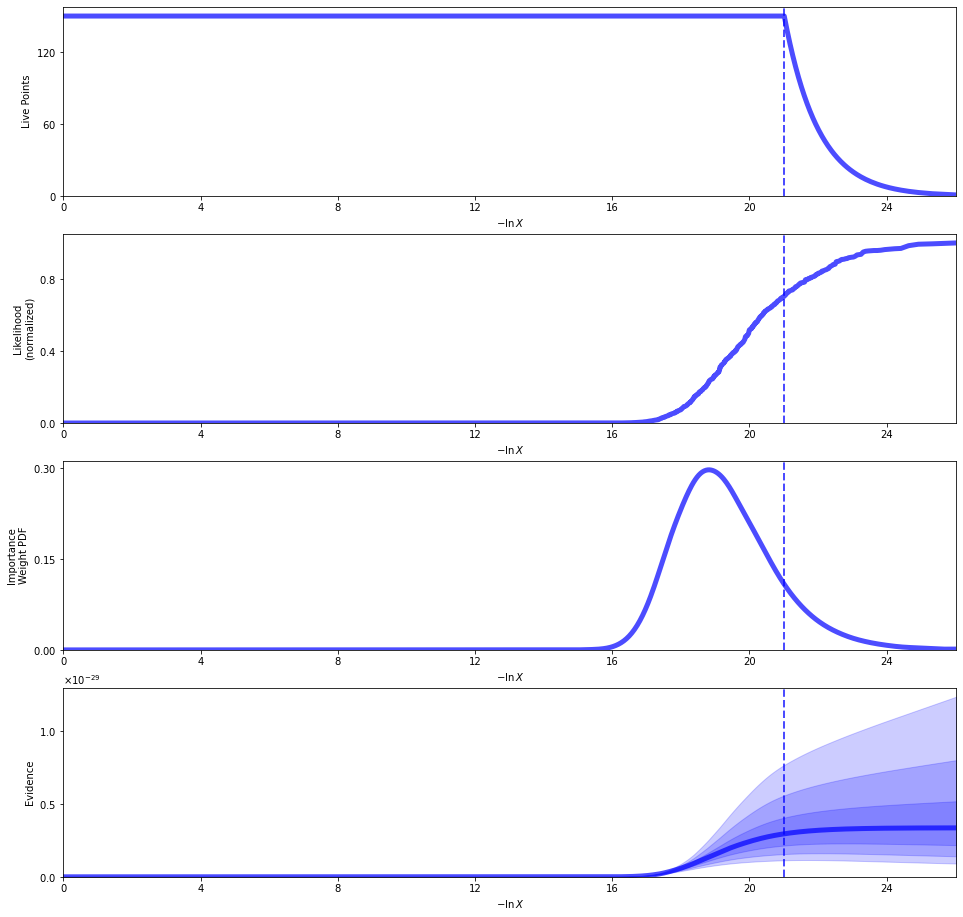

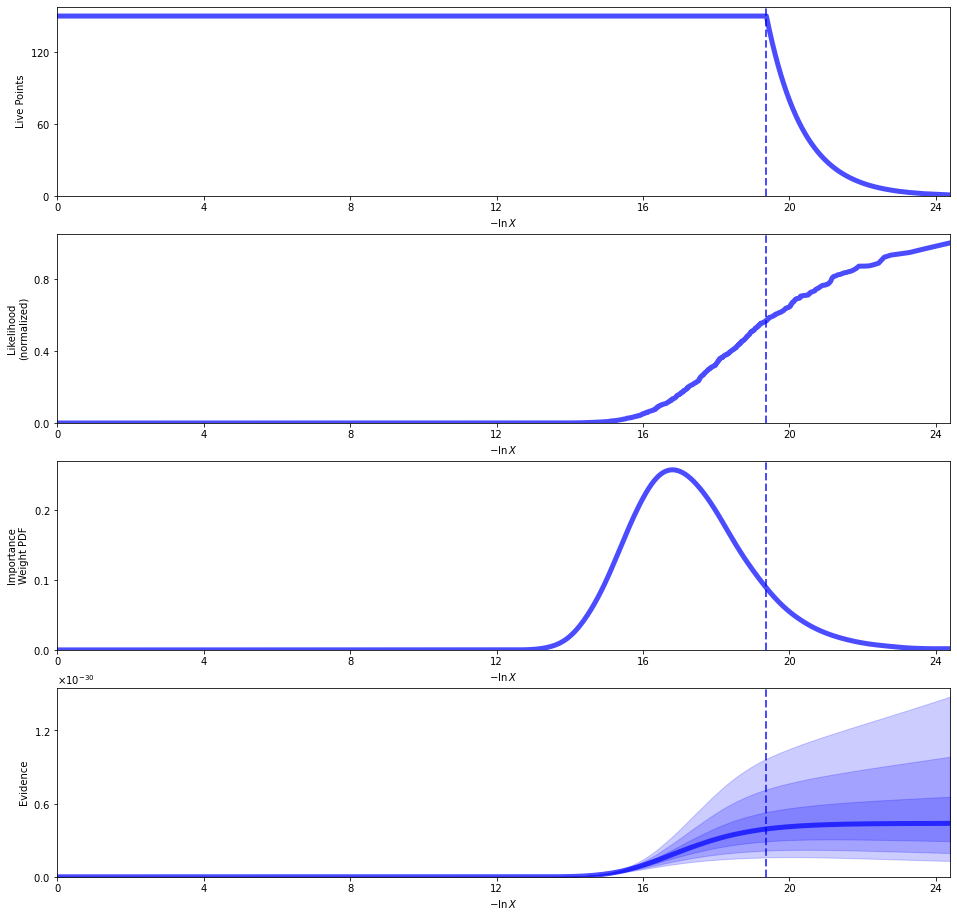

In [7]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)
rfig1, raxes1 = dyplot.runplot(sresults_gauss)

Trace plots show us the evolution of particles (and their marginal pdf) in 1D projection.

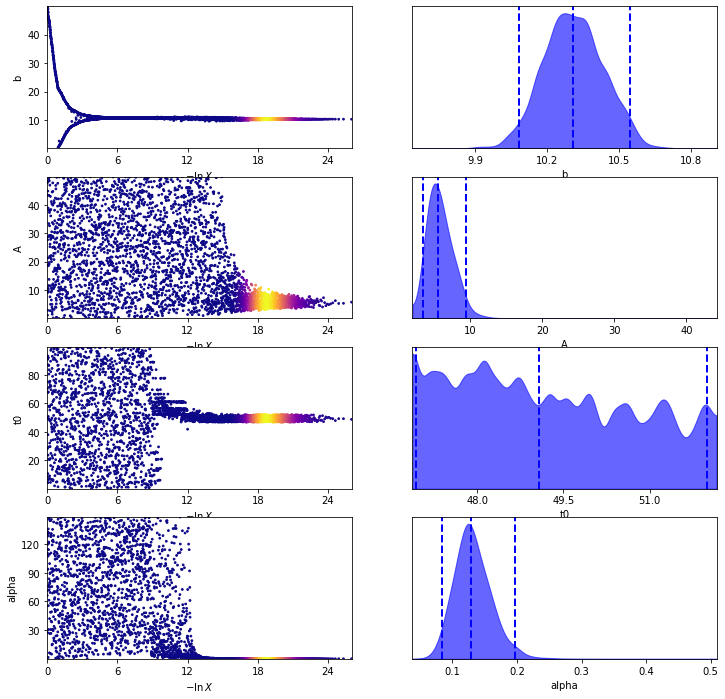

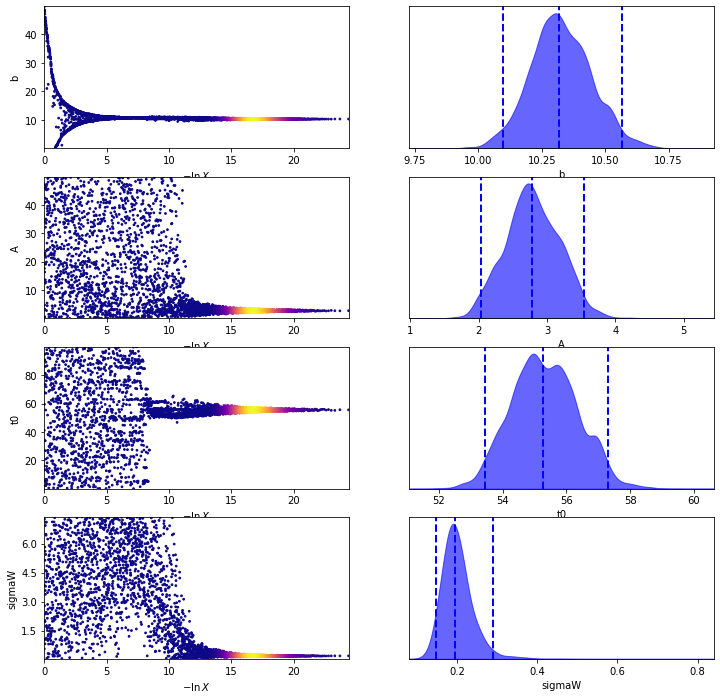

In [8]:
# Trace plots
tfig, taxes = dyplot.traceplot(sresults, labels=['b','A','t0','alpha'])
tfig1, taxes1 = dyplot.traceplot(sresults_gauss, labels=['b','A','t0','sigmaW'])

Corner plots instead show a combbination of 1D and 2d marginalized posteriors. If I use resamples_equal to resample the run I will have samples equal weighted similarly to MCMC methods.

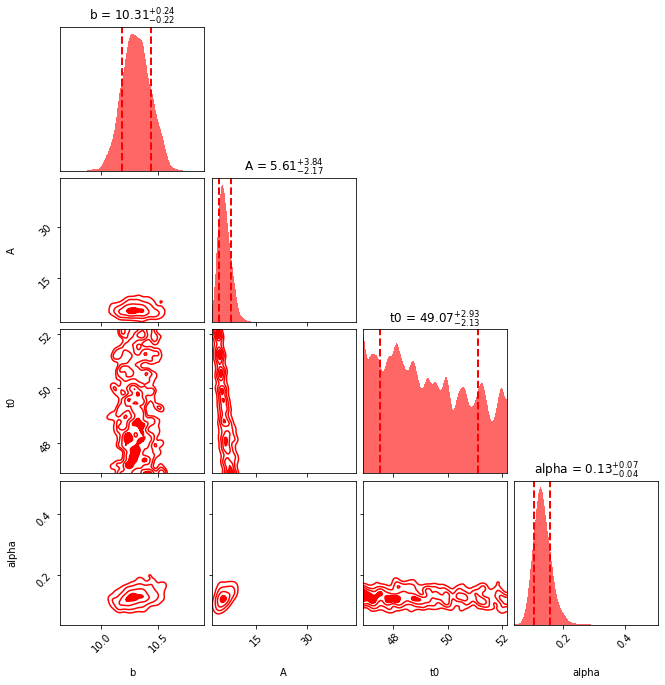

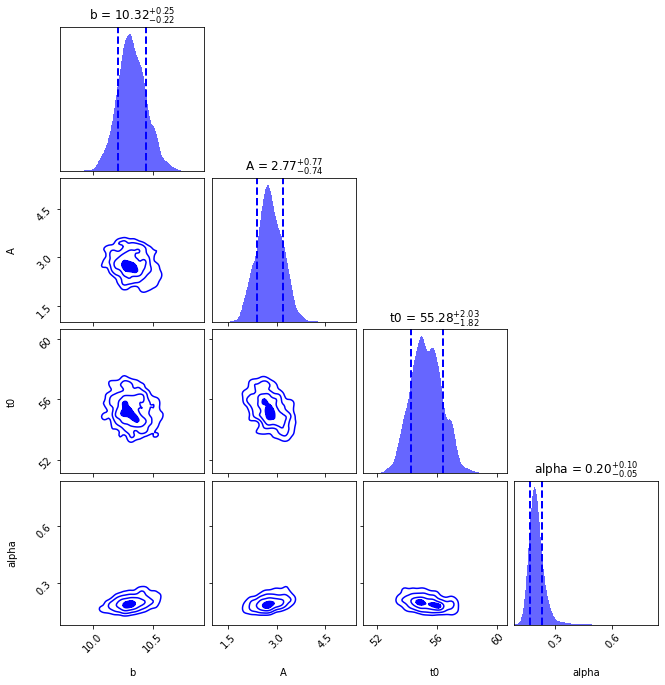

In [66]:
cfig, caxes = dyplot.cornerplot(sresults, labels=['b','A','t0','alpha'],color='red', truths=np.zeros(4),
                           truth_color='black', show_titles=True,
                           max_n_ticks=3, quantiles=[0.16, 0.84]
                           )


cfig1, caxes1 = dyplot.cornerplot(sresults_gauss, labels=['b','A','t0','alpha'],color='blue', truths=np.zeros(4),
                           truth_color='black', show_titles=True,
                           max_n_ticks=3, quantiles=[0.16, 0.84]
                           )



Assuming same priors we compute the Odds ratio. In particular I'm interested in the bayes factor which is the ratio of the two models evidence distibution.  As we can see we have a "substatntial" strenght in favour of burst model.

In [24]:
evidence = sresults.logz[-1] #evidence in log scale
print("Bayesian evidence burst model", np.exp(evidence))

evidence_gauss = sresults_gauss.logz[-1] #evidence in log
print("Bayesian evidence gauss model", np.exp(evidence_gauss))

print('Bayes factor = burst_model / gauss_model = ' , np.exp(evidence - evidence_gauss))

Bayesian evidence burst model 3.3471711436677506e-30
Bayesian evidence gauss model 4.378813683317453e-31
Bayes factor = burst_model / gauss_model =  7.644013620446817


I plot the posterior pdf to check the results on the data. 

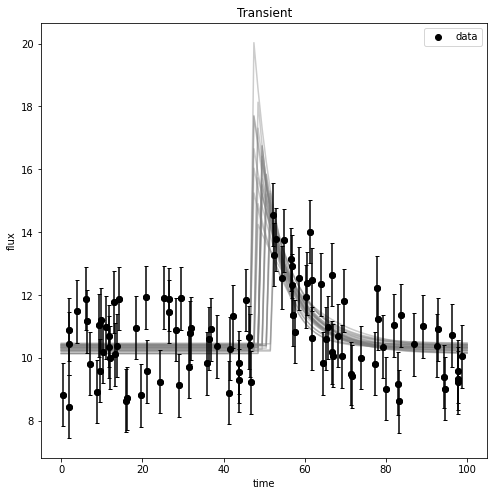

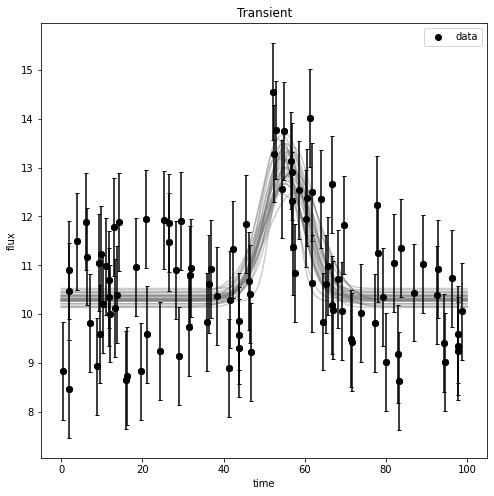

In [53]:
#samples, weights = sresults.samples, sresults.importance_weights()
#samples_gauss, weights_gauss = sresults_gauss.samples, sresults_gauss.importance_weights()

new_samples = sresults.samples_equal() # weights are equal as in MCMC
new_samples_gauss = sresults_gauss.samples_equal()

tt=np.linspace(0,100,100)

random_samples = new_samples[np.random.randint(0,len(new_samples),30)]
random_samples_gauss = new_samples_gauss[np.random.randint(0,len(new_samples_gauss),30)]

plt.figure(figsize=(8,8))
for i in range(len(random_samples)):
    plt.plot(tt, burst_model(random_samples[i][0],random_samples[i][1],random_samples[i][2],random_samples[i][3] ,tt)
                ,c='gray', alpha=0.4)
plt.scatter(data[:,0],data[:,1], marker='o',color='black', label='data')
plt.errorbar(data[:,0],data[:,1],yerr=data[:,2], fmt='o', color='black', capsize=2)
plt.xlabel('time')
plt.ylabel('flux')
plt.title('Transient')
plt.legend(loc=0)

plt.figure(figsize=(8,8))
for i in range(len(random_samples_gauss)):
    plt.plot(tt, gaussian_model(random_samples_gauss[i][0],random_samples_gauss[i][1],random_samples_gauss[i][2],random_samples_gauss[i][3] ,tt)
                ,c='gray', alpha=0.4)
plt.scatter(data[:,0],data[:,1], marker='o',color='black', label='data')
plt.errorbar(data[:,0],data[:,1],yerr=data[:,2], fmt='o', color='black', capsize=2)
plt.xlabel('time')
plt.ylabel('flux')
plt.title('Transient')
plt.legend(loc=0)





